<a href="https://colab.research.google.com/github/Intelligent-QuestionMark/Mobile-Phone-Price-Prediction/blob/smartphones-dataset-svr/Smartphones%20Dataset/Smartphones_SVR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

## The dataset

In [311]:
import pandas as pd

data = pd.read_csv("smartphones.csv")
print(data.head())
y = data['price']

  brand_name                    model   price  avg_rating  5G_or_not  \
0      apple          Apple iPhone 11   38999        7.30          0   
1      apple  Apple iPhone 11 (128GB)   46999        7.50          0   
2      apple  Apple iPhone 11 Pro Max  109900        7.70          0   
3      apple          Apple iPhone 12   51999        7.40          1   
4      apple  Apple iPhone 12 (128GB)   55999        7.50          1   

  processor_brand  num_cores  processor_speed  battery_capacity  \
0          bionic       6.00             2.65           3110.00   
1          bionic       6.00             2.65           3110.00   
2          bionic       6.00             2.65           3500.00   
3          bionic       6.00             3.10               NaN   
4          bionic       6.00             3.10               NaN   

   fast_charging_available  fast_charging  ram_capacity  internal_memory  \
0                        0            NaN             4               64   
1           

Using TargetEncoder to encode categorical features

In [312]:
from sklearn.preprocessing import TargetEncoder

encoder = TargetEncoder(target_type="continuous")
data['brand_name_encoded'] = encoder.fit_transform(data[['brand_name']], y)
data['processor_brand_encoded'] = encoder.fit_transform(data[['processor_brand']], y)
data['os_encoded'] = encoder.fit_transform(data[['os']], y)

del data['model']
del data['brand_name']
del data['processor_brand']
del data['os']

Drop samples with empty columns and separate features from target feature, price. Then select the top 10 features based on their mutual information (nat) score.

In [313]:
from sklearn.feature_selection import mutual_info_regression, SelectKBest
data = data.dropna()

y = data['price']
dollars = []
for price in y:
    dollars.append(int(price) / 100)
y = pd.DataFrame(dollars)
X = data.drop('price', axis=1)


mutual_info = mutual_info_regression(X, y)

# Create a DataFrame for better visualization
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': mutual_info,
}).sort_values(by='Score', ascending=False)

# Display the feature importance scores
print(feature_scores)

select = SelectKBest(mutual_info_regression, k=10).fit(X, y)
X = select.transform(X)
print(f"\nSelected Features: {select.get_feature_names_out()}")

                      Feature  Score
0                  avg_rating   0.81
3             processor_speed   0.55
7                ram_capacity   0.48
6               fast_charging   0.43
8             internal_memory   0.40
13       primary_camera_front   0.33
9                 screen_size   0.28
14  extended_memory_available   0.25
10               refresh_rate   0.24
4            battery_capacity   0.22
15          resolution_height   0.22
1                   5G_or_not   0.22
18    processor_brand_encoded   0.21
16           resolution_width   0.20
12        primary_camera_rear   0.19
11           num_rear_cameras   0.11
19                 os_encoded   0.05
5     fast_charging_available   0.02
17         brand_name_encoded   0.02
2                   num_cores   0.01

Selected Features: ['avg_rating' 'processor_speed' 'fast_charging' 'ram_capacity'
 'internal_memory' 'screen_size' 'refresh_rate' 'primary_camera_front'
 'extended_memory_available' 'resolution_height']


c:\Users\andre\Documents\GitHub\Mobile-Phone-Price-Prediction\.venv\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\andre\Documents\GitHub\Mobile-Phone-Price-Prediction\.venv\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Training and testing

Scaling features

In [314]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
scaled_X = sc_X.fit_transform(X)
scaled_y = sc_y.fit_transform(y.to_numpy().reshape(-1, 1))

Split the dataset into test data and training data

In [315]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_X, scaled_y, test_size=0.1)

Fit the training data to the model, and test by performing predictions on the test data

In [316]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train, y_train)

pred = regressor.predict(X_test)
pred = pd.DataFrame(pred)

# Revert scaled values to price information
predicted_price = sc_y.inverse_transform(pred)
real_price = sc_y.inverse_transform(y_test)

c:\Users\andre\Documents\GitHub\Mobile-Phone-Price-Prediction\.venv\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Summarize performance

Train accuracy: 0.45493362072255084
Test accuracy: 0.7977293749250545
RMSE: $65.13932108333728


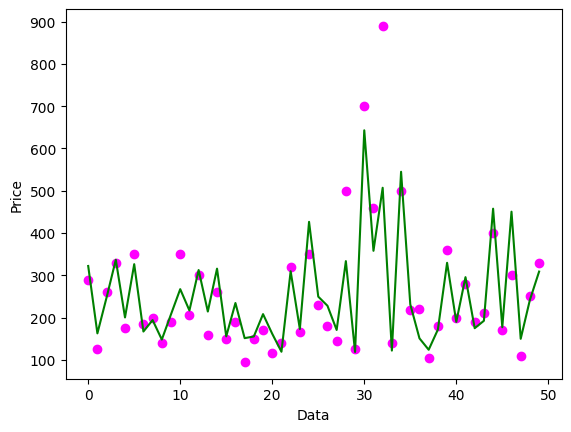

In [317]:
from sklearn.metrics import root_mean_squared_error

print(f"Train accuracy: {regressor.score(X_train, y_train)}")
print(f"Test accuracy: {regressor.score(X_test, y_test)}")
print(f"RMSE: ${root_mean_squared_error(real_price, predicted_price)}")

import matplotlib.pyplot as plt
graph_points = 50
plt.scatter(range(graph_points), real_price[:graph_points], color = 'magenta')
plt.plot(range(graph_points), predicted_price[:graph_points], color = 'green')
plt.xlabel('Data')
plt.ylabel('Price')
plt.show()